In [1]:
from pathlib import Path
from IPython.display import display, Markdown
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap, HeatMapWithTime
from ctcrash.utils import (
    CTCrashData,
    create_map,    
    create_pivot_table,
    pivot_table_with_totals_to_heatmap,
    read_csv,    
)

In [2]:
data_directory = Path("data/norwalk_2021_2024")
data_date_range = '2021 to 2024'
chart_title_prefix = f'of {data_date_range} Norwalk Crash Data involving a non-motorist'
crashes_csv = data_directory / "crashes.csv"
persons_csv = data_directory / "persons.csv"
vehicles_csv = data_directory / "vehicles.csv"

In [3]:
crashes_columns = [
    'CrashId',
    'Latitude',
    'Longitude',
    'Date Of Crash',
    'Time of Crash',
    # 'Crash Severity',
    'Crash Severity Text Format',
    # 'Most Severe Injury',
    'Most Severe Injury Text Format',
    'Number Of Non-Motorist',
    'Route Class',
    'Route Class Text Format',
    'Roadway Name',
    'Intersecting Roadway Name',
    'First Harmful Event Text Format',
    'Manner of Crash / Collision Impact Text Format',
    # 'Weather Condition Text Format',
    'Average Daily Traffic'
]
crashes = read_csv(crashes_csv, crashes_columns)

In [4]:
persons_columns = [
    'CrashId',
    'VehicleId',
    'PersonId',
    'Age',
    # 'Gender',
    'Gender Text Format',
    'Injury Status Text Format',
    'Condition at Time of Crash Text Format',
    # 'Alcohol Test Status Text Format',
    # 'Drug Test Status Text Format',
    # 'Type Of Drig Test Text Format',
    'Speeding Related Text Format',
    'Helmet Use Text Format',
    'Roadway On Which Nonmotorist Was Traveling/Located',
    'Striking Motor Vehicle ID',
    # 'Bicycle ID',
    'Non-Motorist Not In Roadway',
    'Non-motorist Distracted By Text Format',
    'To or From School Text Format',
    'State',
    # 'Postal Code',
    # 'Person Type',
    'Person Type Text Format',
]
persons = read_csv(persons_csv, persons_columns, encoding_errors='backslashreplace')

In [5]:
vehicles_columns = [
    'CrashId',
    'VehicleId',
    'Vehicle Unit Type Text Format',
    'Number of Occupants in Vehicle',
    'Make',
    'Model',
    # 'Vehicle Model Year Text Format',
    'Most Harmful Event',
    'Vehicle Maneuver/Action Text Format',
    'Contributing Circumstances, Motor Vehicle Text Format',
    'Posted/Statutory Speed Limit',
    # 'Trafficway Description Text Format',
    'Initial Contact Point Text Format',
    'Extent of Damage Text Format',
    'Body Type Text Format',
    'Vehicle Action Text Format',
    'Contributing Circumstances of Vehicle Text Format',
    'Traffic Control Device Type Text Format',
    # 'Traffic Control Device Functional?',
    'Hit And Run Status',
    'Bike Lanes/Sharrows Present',
    'Name Of Roadway On Which Vehicle Was Traveling',
    'Vehicle Was Not On Roadway',
    # 'Motor Vehicle Registration Was Invalid',
    # 'Motor Vehicle Registration Plate Was Missing',
]
vehicles = read_csv(vehicles_csv, vehicles_columns)

In [6]:
full_crash_context = crashes.merge(persons, on='CrashId')
full_crash_context = full_crash_context.merge(vehicles, on='CrashId')

In [7]:
# Number of distinct crashes
full_crash_context.groupby('CrashId')[['CrashId']].nunique().count()

CrashId    236
dtype: int64

In [8]:
min_date = full_crash_context['Date Of Crash'].min()
max_date = full_crash_context['Date Of Crash'].max()

display(Markdown(f'This data ranges from {min_date} to {max_date}. Data exported from https://www.ctcrash.uconn.edu/ using a query of all Norwalk activity from the prior 3 years that involved a non-motorist and included related entities (ie drivers, passengers, and witnesses.)'))

This data ranges from 2021-01-03 to 2024-06-28. Data exported from https://www.ctcrash.uconn.edu/ using a query of all Norwalk activity from the prior 3 years that involved a non-motorist and included related entities (ie drivers, passengers, and witnesses.)

In [9]:
# Distinct person types
full_crash_context.groupby('Person Type Text Format')[['Person Type Text Format']].count()

,Person Type Text Format
Person Type Text Format,
Bicyclist,145
Driver,333
Occupant of a Non-Motor Vehicle Transportation Device,9
Other Cyclist,2
"Other Pedestrian (wheelchair, person in a building, skater, pedestrian conveyance)",6
Passenger,51
Pedestrian,169
Witness,87


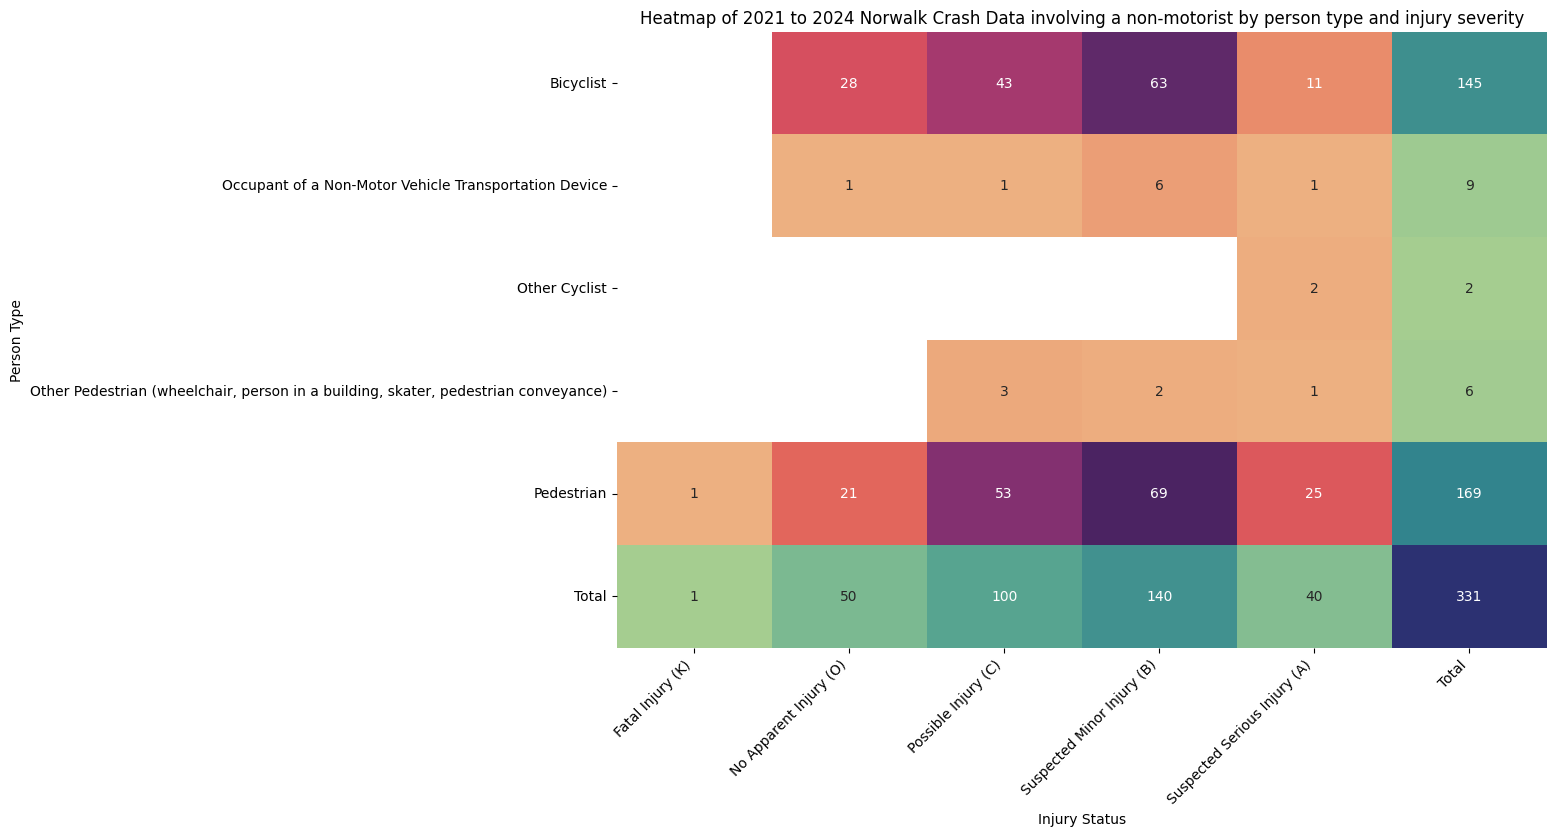

In [10]:
non_motorist_full_crash_context = full_crash_context[~full_crash_context['Person Type Text Format'].isin(['Driver', 'Passenger', 'Witness'])]
events_by_person_and_injury = create_pivot_table(
    non_motorist_full_crash_context,
    'Person Type Text Format',
    'Injury Status Text Format',
)

plt = pivot_table_with_totals_to_heatmap(events_by_person_and_injury)
plt.title(f'Heatmap {chart_title_prefix} by person type and injury severity')
plt.xlabel('Injury Status')
plt.ylabel('Person Type')
plt.xticks(rotation=45, ha='right')
plt.show()

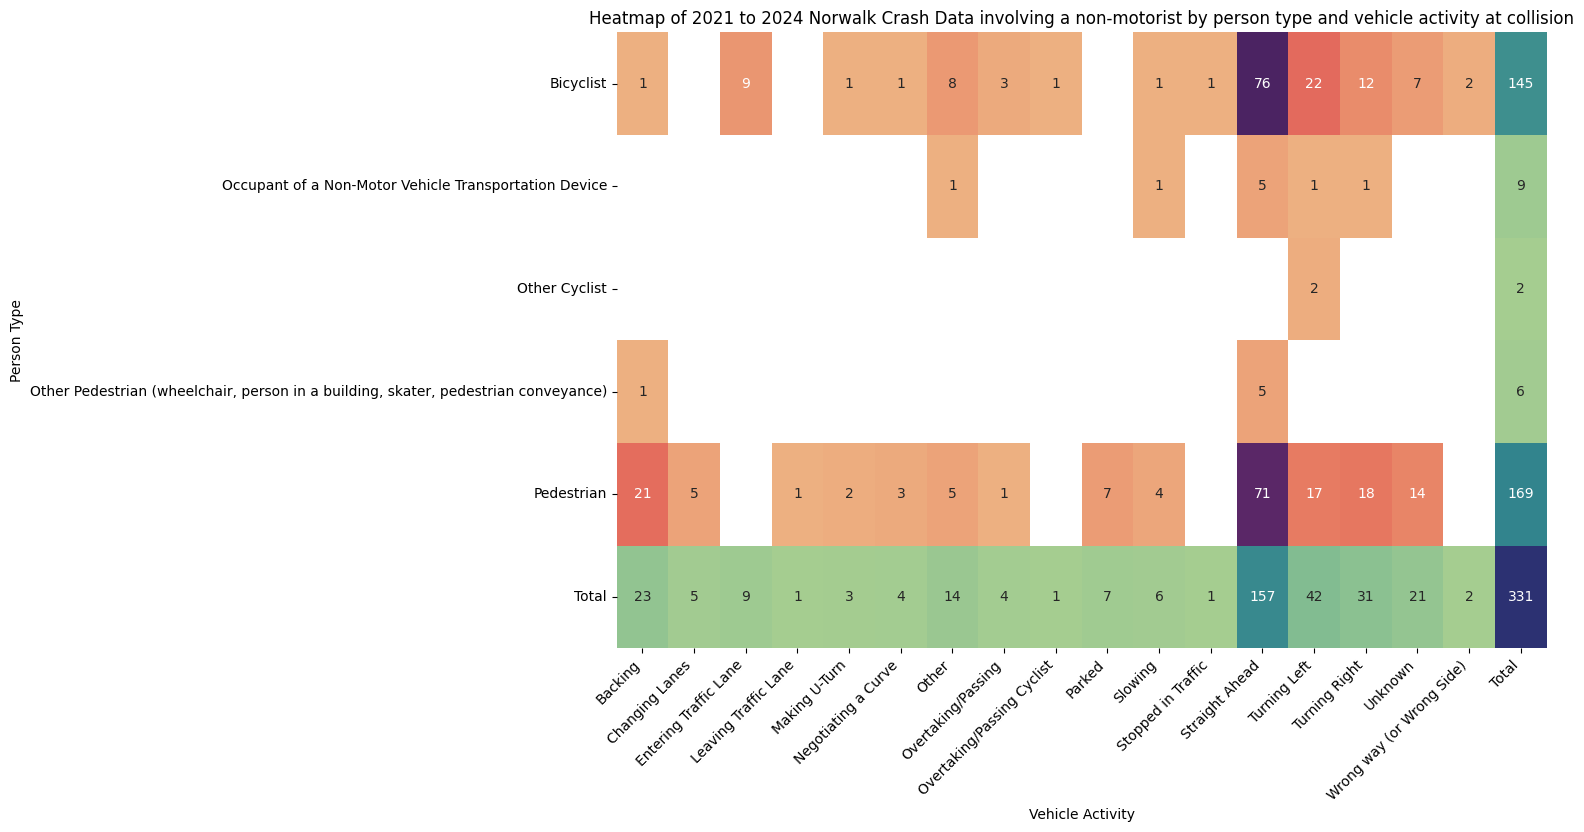

In [11]:
events_by_person_and_vehicle_action = create_pivot_table(non_motorist_full_crash_context, 'Person Type Text Format', 'Vehicle Action Text Format')

plt = pivot_table_with_totals_to_heatmap(events_by_person_and_vehicle_action)
plt.title(f'Heatmap {chart_title_prefix} by person type and vehicle activity at collision')
plt.xlabel('Vehicle Activity')
plt.ylabel('Person Type')
plt.xticks(rotation=45, ha='right')
plt.show()

In [23]:
crash_map = create_map(crashes[['CrashId', 'Latitude', 'Longitude']].drop_duplicates())

title_html = f'<h3 align="center" style="font-size:20px"><b>Heatmap {chart_title_prefix} locations.</b></h3>'
crash_map.get_root().html.add_child(folium.Element(title_html))

crash_map

In [24]:
straight_ahead_crash_map = create_map(non_motorist_full_crash_context[non_motorist_full_crash_context['Vehicle Action Text Format'] == 'Straight Ahead'][['CrashId', 'Latitude', 'Longitude']].drop_duplicates())

title_html = f'<h3 align="center" style="font-size:20px"><b>Heatmap {chart_title_prefix} locations of straight ahead crashes.</b></h3>'
straight_ahead_crash_map.get_root().html.add_child(folium.Element(title_html))
straight_ahead_crash_map

In [25]:
left_turn_crashes = non_motorist_full_crash_context[non_motorist_full_crash_context['Vehicle Action Text Format'] == 'Turning Left'][['CrashId', 'Latitude', 'Longitude']].drop_duplicates()

left_turn_crash_map = create_map(left_turn_crashes)

title_html = f'<h3 align="center" style="font-size:20px"><b>Heatmap {chart_title_prefix} locations of left turn crashes.</b></h3>'
left_turn_crash_map.get_root().html.add_child(folium.Element(title_html))
left_turn_crash_map

In [26]:
right_turn_crashes = non_motorist_full_crash_context[non_motorist_full_crash_context['Vehicle Action Text Format'] == 'Turning Right'][['CrashId', 'Latitude', 'Longitude']].drop_duplicates()

right_turn_crash_map = create_map(right_turn_crashes)

title_html = f'<h3 align="center" style="font-size:20px"><b>Heatmap {chart_title_prefix} locations of right turn crashes.</b></h3>'
right_turn_crash_map.get_root().html.add_child(folium.Element(title_html))
right_turn_crash_map

In [16]:
speeding_related = create_pivot_table(full_crash_context, 'Speeding Related Text Format', 'Person Type Text Format')
speeding_related

Person Type Text Format,Driver,Total
Speeding Related Text Format,,
Exceeded Speed Limit,4,4
No,222,222
Too Fast for Conditions,10,10
Unknown,97,97
Total,333,333


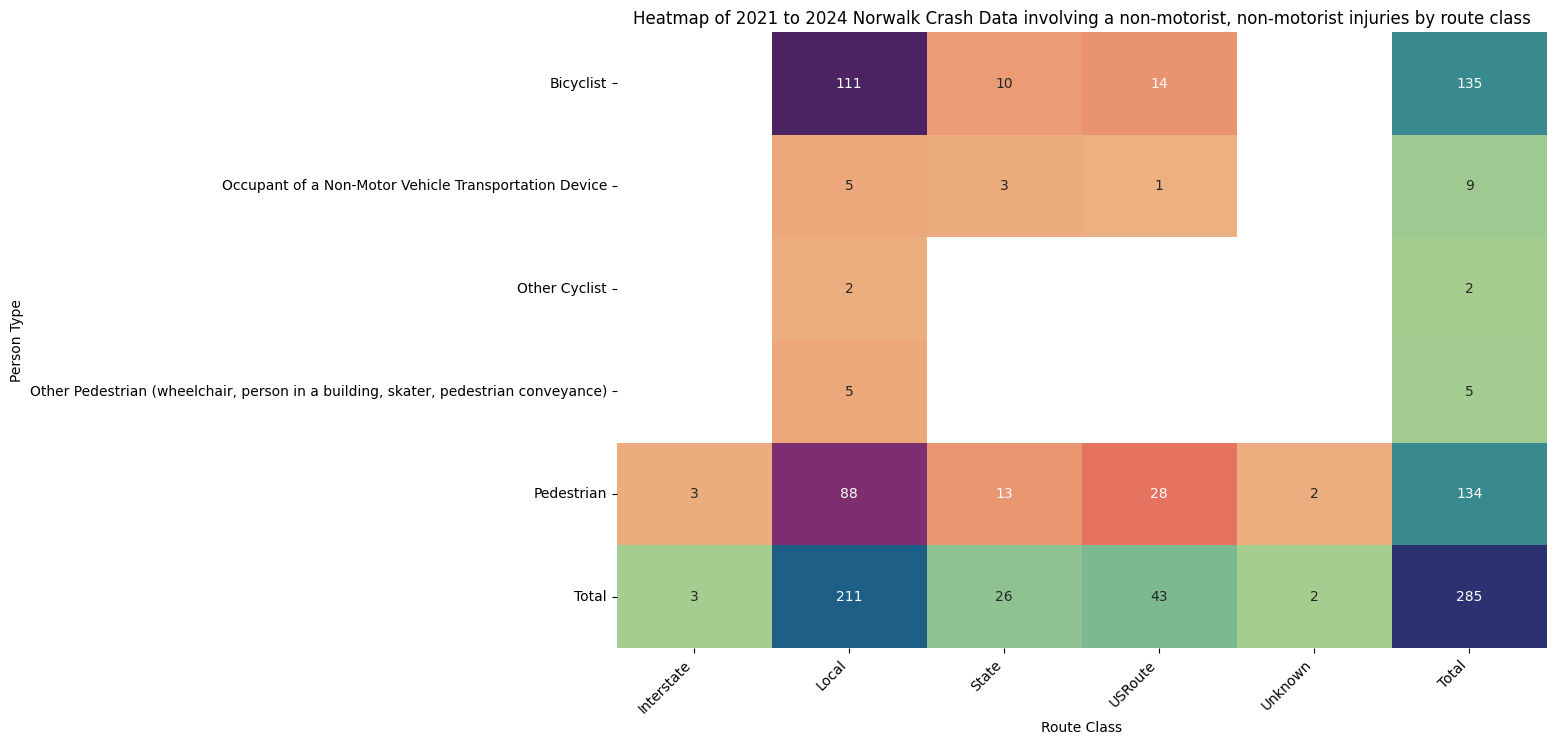

In [17]:
route_class = create_pivot_table(non_motorist_full_crash_context, 'Person Type Text Format', 'Route Class Text Format')

plt = pivot_table_with_totals_to_heatmap(route_class)
plt.title(f'Heatmap {chart_title_prefix}, non-motorist injuries by route class')
plt.xlabel('Route Class')
plt.ylabel('Person Type')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0, ha='right')
plt.show()

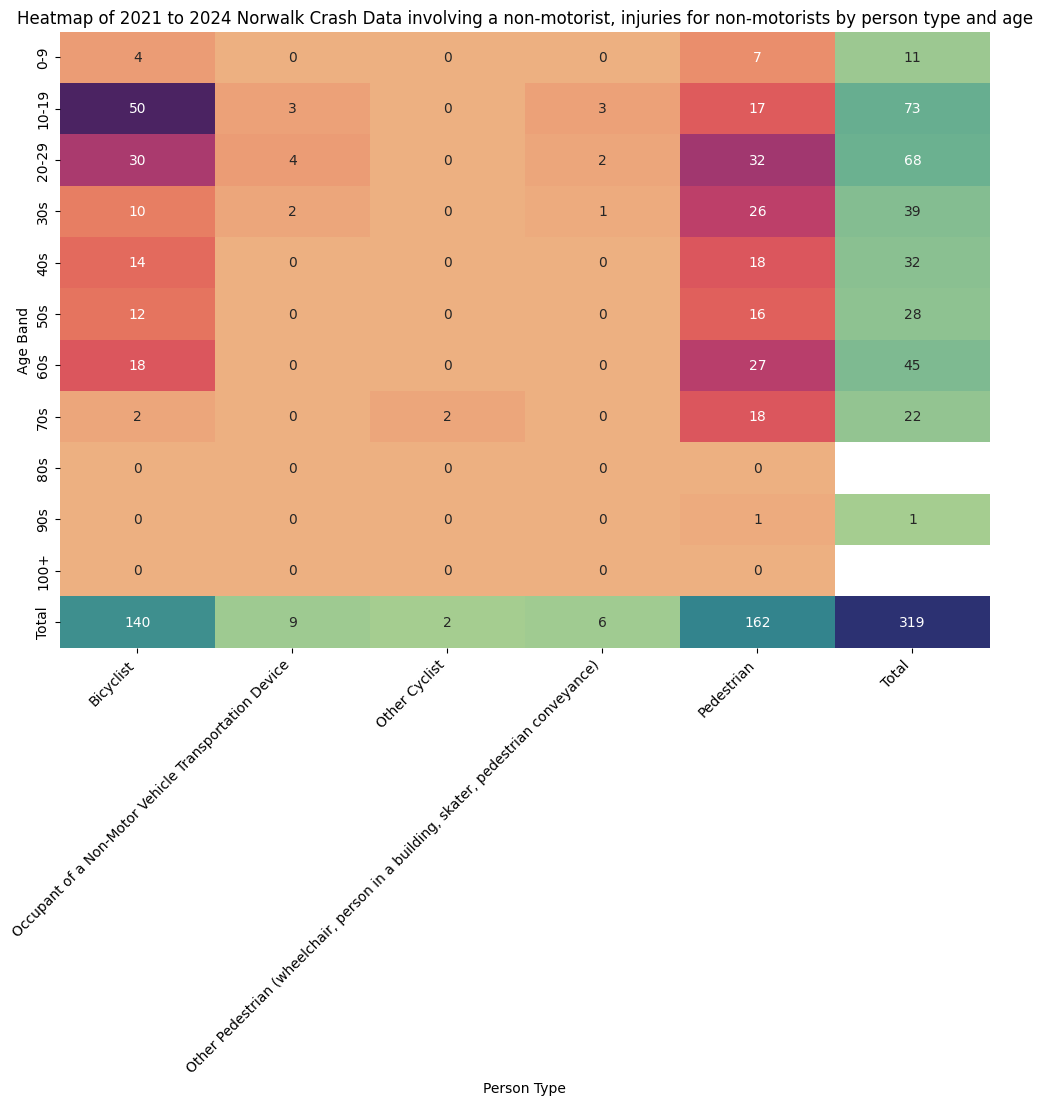

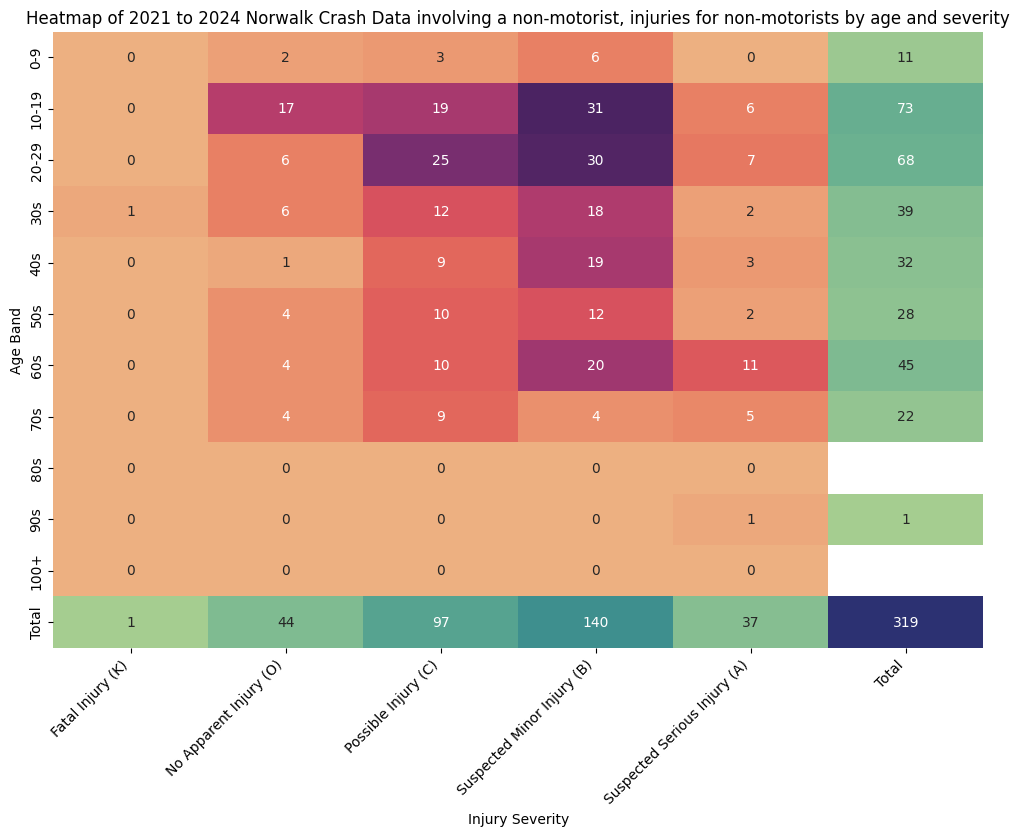

In [18]:
# Create groupings of persons by age range, using even 10 year bands
age_bins = [0, 9, 19, 29, 39, 49, 59, 69, 79, 89, 99, 120]
age_labels = ['0-9', '10-19', '20-29', '30s', '40s', '50s', '60s', '70s', '80s', '90s', '100+']
full_crash_context['Age Band'] = pd.cut(full_crash_context['Age'], bins=age_bins, labels=age_labels, right=False)

# Non-motorists
injured_person_rows = full_crash_context[full_crash_context['Injury Status Text Format'].notna()]
non_motorists_injured_person_rows = injured_person_rows[~injured_person_rows['Person Type Text Format'].isin(['Driver', 'Passenger'])]

person_injured_by_age = create_pivot_table(non_motorists_injured_person_rows, 'Age Band', 'Person Type Text Format')

plt = pivot_table_with_totals_to_heatmap(person_injured_by_age)
plt.title(f'Heatmap {chart_title_prefix}, injuries for non-motorists by person type and age')
plt.xlabel('Person Type')
plt.ylabel('Age Band')
plt.xticks(rotation=45, ha='right')
plt.show()

injurry_severity_by_age = create_pivot_table(non_motorists_injured_person_rows, 'Age Band', 'Injury Status Text Format')

plt = pivot_table_with_totals_to_heatmap(injurry_severity_by_age)
plt.title(f'Heatmap {chart_title_prefix}, injuries for non-motorists by age and severity')
plt.xlabel('Injury Severity')
plt.ylabel('Age Band')
plt.xticks(rotation=45, ha='right')
plt.show()

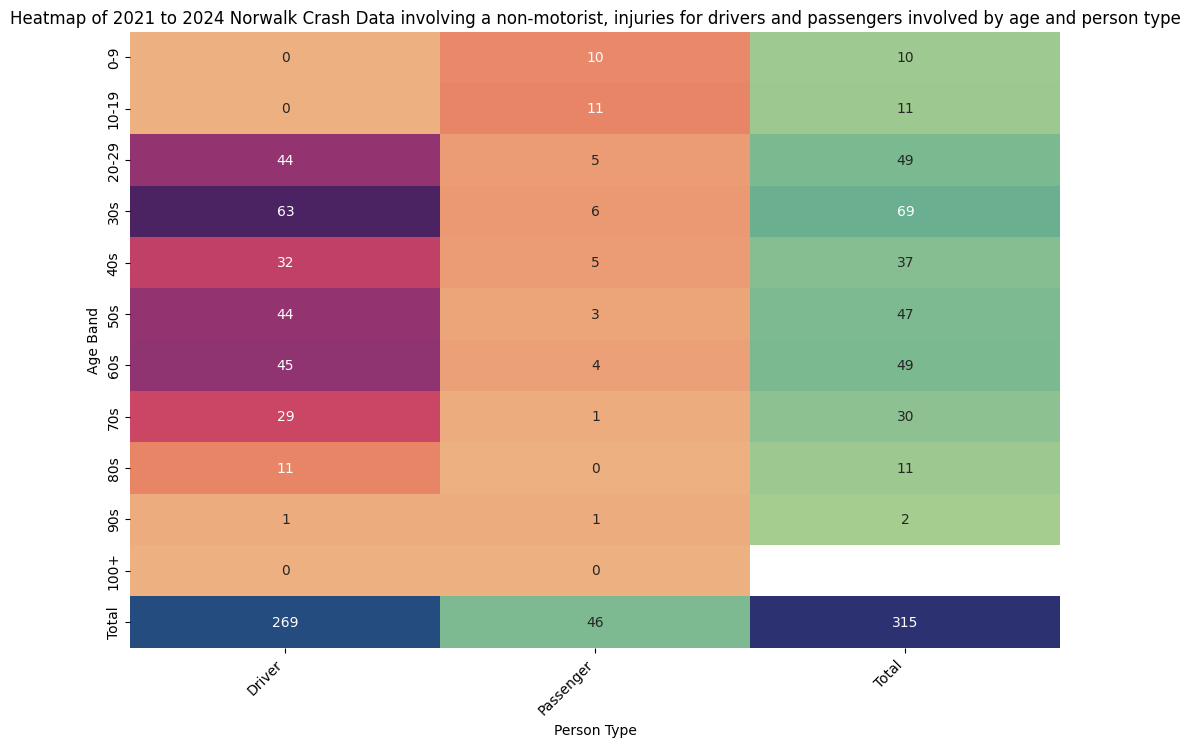

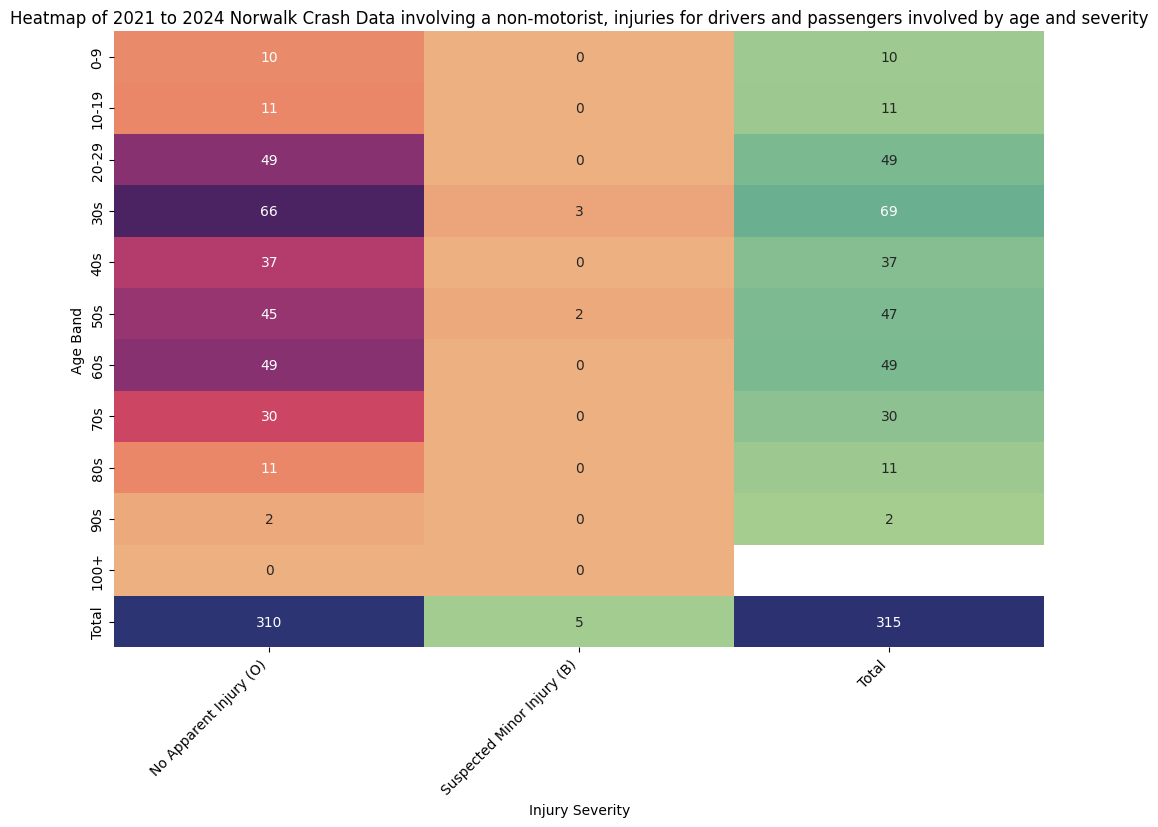

In [19]:
motorists_rows = injured_person_rows[injured_person_rows['Person Type Text Format'].isin(['Driver', 'Passenger'])]

drivers_by_age_and_injury = create_pivot_table(motorists_rows, 'Age Band', 'Person Type Text Format')

plt = pivot_table_with_totals_to_heatmap(drivers_by_age_and_injury)
plt.title(f'Heatmap {chart_title_prefix}, injuries for drivers and passengers involved by age and person type')
plt.xlabel('Person Type')
plt.ylabel('Age Band')
plt.xticks(rotation=45, ha='right')
plt.show()

drivers_by_age_and_injury = create_pivot_table(motorists_rows, 'Age Band', 'Injury Status Text Format')

plt = pivot_table_with_totals_to_heatmap(drivers_by_age_and_injury)
plt.title(f'Heatmap {chart_title_prefix}, injuries for drivers and passengers involved by age and severity')
plt.xlabel('Injury Severity')
plt.ylabel('Age Band')
plt.xticks(rotation=45, ha='right')
plt.show()

In [27]:
# Including 18 year olds, as that population likely includes high school seniors
children_injured = non_motorist_full_crash_context[non_motorist_full_crash_context['Age'] <= 18]
child_injuries_heatmap = create_map(children_injured)

title_html = f'<h3 align="center" style="font-size:20px"><b>Heatmap {chart_title_prefix} locations of injuries involving children.</b></h3>'
child_injuries_heatmap.get_root().html.add_child(folium.Element(title_html))
child_injuries_heatmap

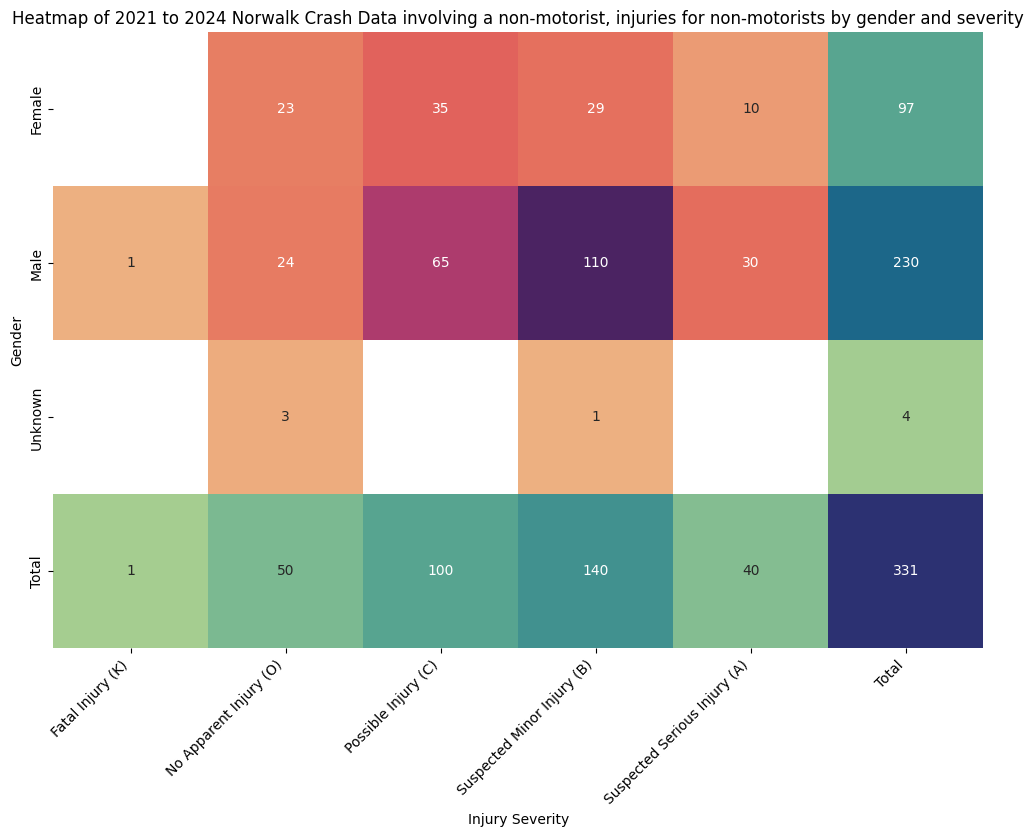

In [21]:
non_motorist_injury_severity_by_gender = create_pivot_table(non_motorists_injured_person_rows, 'Gender Text Format', 'Injury Status Text Format')

plt = pivot_table_with_totals_to_heatmap(non_motorist_injury_severity_by_gender)
plt.title(f'Heatmap {chart_title_prefix}, injuries for non-motorists by gender and severity')
plt.xlabel('Injury Severity')
plt.ylabel('Gender')
plt.xticks(rotation=45, ha='right')
plt.show()

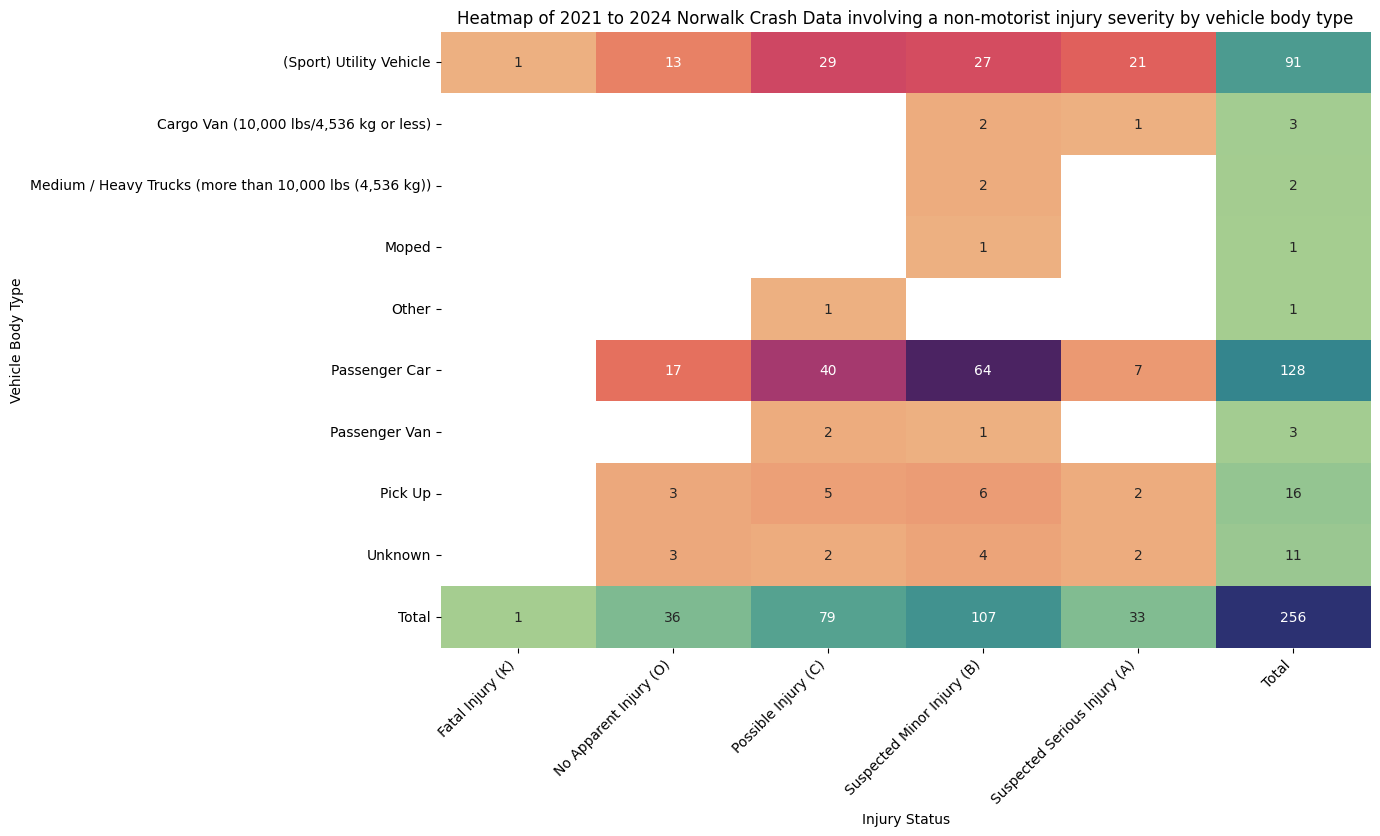

In [22]:
route_class = create_pivot_table(non_motorist_full_crash_context, 'Body Type Text Format', 'Injury Status Text Format')

plt = pivot_table_with_totals_to_heatmap(route_class)
plt.title(f'Heatmap {chart_title_prefix} injury severity by vehicle body type')
plt.xlabel('Injury Status')
plt.ylabel('Vehicle Body Type')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0, ha='right')
plt.show()